In [66]:
from nltk.tokenize import sent_tokenize

import ollama

import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import pairwise_distances


from reco_systems.filter import filter_df
from reco_systems.llm import *
from reco_systems.CF_knn import *
from reco_systems.user_game_matrix import *
from reco_systems.evaluation import *
from reco_systems.text_filtering import *
from reco_systems.lemmatization import *
from reco_systems.embeds_utils import *

from sklearn.feature_extraction.text import CountVectorizer
from treetaggerwrapper import TreeTagger
from nltk.corpus import stopwords
from nltk import word_tokenize
import textwrap
from string import punctuation
from unicodedata import normalize
from unidecode import unidecode
from itertools import product

from surprise import NMF
from surprise import Dataset
from surprise.reader import Reader

sns.set_theme()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
folder = "../database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 10 
rev_filter = filter_df(avis_clean, min_reviews)

rev_filter = rev_filter.assign(index=rev_filter.index)
rev_filter["Length"] = rev_filter["Comment body"].str.split().apply(len)

lemmas = pd.read_csv("../generated_data/Lemmas_VER_cleaned.csv")
corpus = construction_corpus(lemmas, 5000)
lemmas = lemmas[lemmas["Lemma"].isin(corpus)]

comments_lemmatized = lemmas.groupby("Comment line")["Lemma"].apply(" ".join).reset_index()
rev_filter = rev_filter[rev_filter["index"].isin(comments_lemmatized["Comment line"])]
comments_lemmatized = comments_lemmatized.merge(rev_filter[["Game id", "User id", "index"]], left_on="Comment line", right_on="index")

rev_filter, _ = center_score(rev_filter)
users_means = rev_filter[["User id", "Rating"]].groupby("User id").mean().reset_index()

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


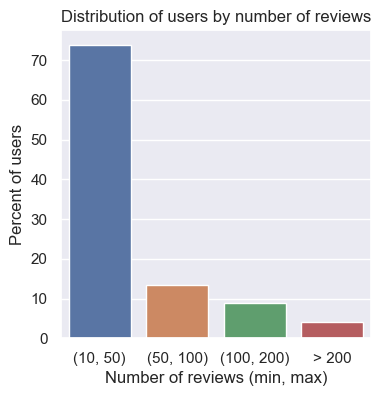

In [64]:
users_count = rev_filter.groupby("User id")["Game id"].count()
#sns.histplot(users_count, bins=[0, 50, 100, 200, users_count.max()], stat="percent")
counts, values = np.histogram(users_count, bins=[10, 50, 100, 200, users_count.max()])
counts = np.round(counts / np.sum(counts) * 100, 1)

labels = [f"({values[i]}, {values[i+1]})" for i in range(len(values) - 1)]
labels[3] = "> 200"

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
df = pd.DataFrame(data={"Percent of users":counts, "Number of reviews":labels})
sns.barplot(data=df, x="Number of reviews", y="Percent of users", ax=ax, hue="Number of reviews")
ax.set_xlabel("Number of reviews (min, max)")
ax.set_title("Distribution of users by number of reviews")
fig.savefig("../images/users_activity_barplots.svg", bbox_inches="tight", format="svg")

In [151]:
matrix_ratings, mask_ratings, users_table, games_table = get_matrix_user_game(rev_filter)
cos_dist_matrix = calc_similarity_matrix(matrix_ratings, mask_ratings, "cos")
eucl_dist_matrix = calc_similarity_matrix(matrix_ratings, mask_ratings, "euclidean")
matrix_ratings

<Compressed Sparse Row sparse array of dtype 'float64'
	with 96459 stored elements and shape (1945, 2614)>

/Users/bsh2022/Study/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


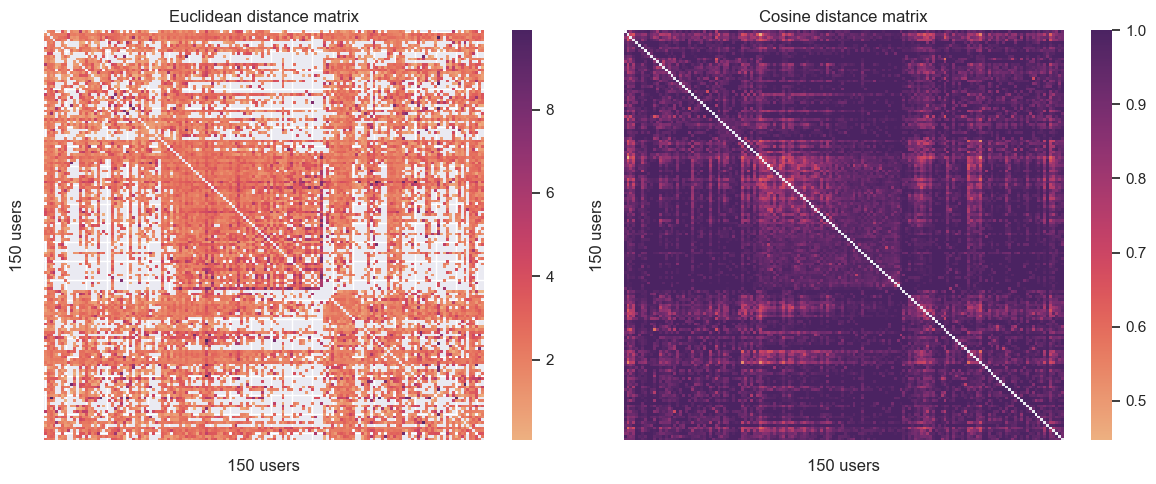

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

mask = (eucl_dist_matrix == 0)
eucl_dist_matrix[mask] = np.nan
eucl_dist_matrix[np.diag_indices(eucl_dist_matrix.shape[0])] = np.nan
cos_dist_matrix[np.diag_indices(cos_dist_matrix.shape[0])] = np.nan

#sns.heatmap(eucl_dist_matrix.toarray()[:500, :500], cmap="viridis_r", ax=ax1)

N = 150
sns.heatmap(eucl_dist_matrix.toarray()[:N, :N], cmap="flare", ax=ax1)
sns.heatmap(cos_dist_matrix[:N, :N], cmap="flare", ax=ax2)

ax1.set_title("Euclidean distance matrix")
ax2.set_title("Cosine distance matrix")

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax1.set_yticklabels([])
ax2.set_yticklabels([])

ax1.set_ylabel("150 users")
ax2.set_ylabel("150 users")

ax1.set_xlabel("150 users")
ax2.set_xlabel("150 users")

plt.tight_layout()
fig.savefig("../images/matrix_distances.png", bbox_inches="tight", format="png", dpi=150)

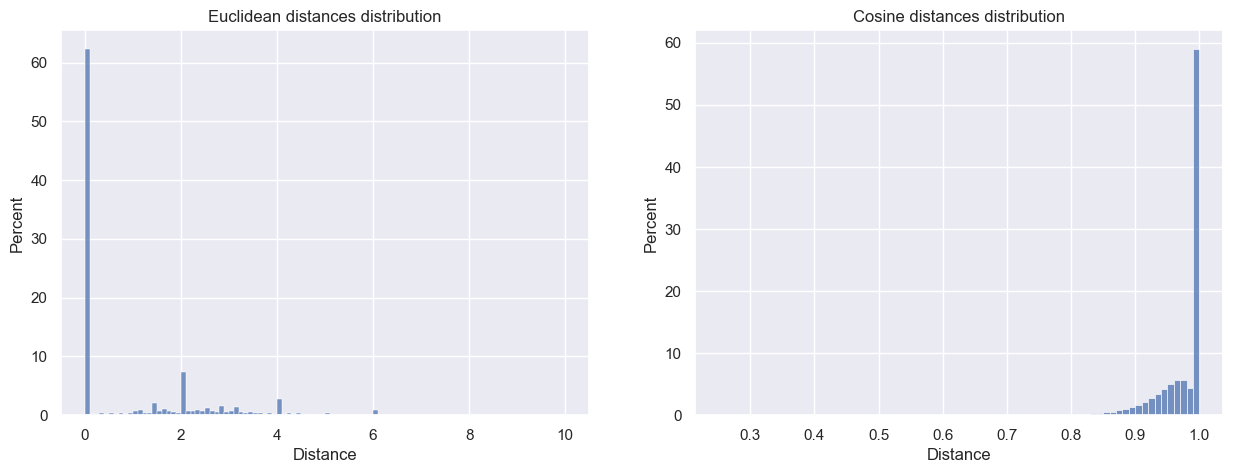

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
distances_cos = cos_dist_matrix.flatten()
distances_cos = distances_cos[distances_cos > 0]
sns.histplot(distances_cos, binwidth=0.01, stat="percent", ax=ax2)
ax2.set_title("Cosine distances distribution")
ax2.set_xlabel("Distance")

sns.histplot(eucl_dist_matrix.toarray().flatten(), binwidth=0.1, stat="percent", ax=ax1)
ax1.set_title("Euclidean distances distribution")
ax1.set_xlabel("Distance")
fig.savefig("../images/cos_eucl_dist_distr.svg", bbox_inches="tight", format="svg")

# Phrase embeddings with `BAAI/BG3`

### Sentence splitting

In [202]:
# rev_filter_embed = rev_filter.copy()

# # Unicode normalization
# rev_filter_embed.loc[:, "Comment body"] = rev_filter_embed["Comment body"].apply(lambda row : normalize("NFKC", row))

# # Replace extra caracters that served as a separation
# rev_filter_embed.loc[:, "Comment body"] = rev_filter_embed["Comment body"].str.replace(r"\*{15,}", " ", regex=True)
# rev_filter_embed.loc[:, "Comment body"] = rev_filter_embed["Comment body"].str.replace(r"-{10,}", " ", regex=True)

# # Add space after . or ? or ! for phrases 
# rev_filter_embed.loc[:, "Comment body"] = rev_filter_embed["Comment body"].str.replace(r'([.!?\)])(?=\S)', r'\1 ', regex=True)

# # replace /' by '
# rev_filter_embed.loc[:, "Comment body"] = rev_filter_embed["Comment body"].str.replace(r"\\{1,}'", r"'", regex=True)

# # Delete *** (more that 7 times) 
# rev_filter_embed["Phrases"] = rev_filter_embed["Comment body"].apply(sent_tokenize)
# rev_filter_embed = rev_filter_embed[["Game id", "User id", "index", "Phrases"]]
# rev_filter_embed = rev_filter_embed.explode("Phrases")

# # Delete phrases that contains only regex
# punc_regex = r"^[^\w\s]+$"
# rev_filter_embed = rev_filter_embed[~rev_filter_embed["Phrases"].str.match(punc_regex, na=False)]
# rev_filter_embed["Length"] = rev_filter_embed["Phrases"].str.split().apply(len)
# rev_filter_embed["Length"].sort_values().tail(10)
# rev_filter_embed.shape

### Embeddings

In [203]:
# # Embed separately 
# long_row = rev_filter_embed[rev_filter_embed["Length"] > 700]
# rev_filter_embed = rev_filter_embed.drop(long_row.index)

# from FlagEmbedding import BGEM3FlagModel

# model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True) # Setting use_fp16 to True speeds up computation with a slight performance degradation

# phrases = rev_filter_embed["Phrases"].tolist()

# Time spent : 10h37min
# # Batch encode
# encoded = model.encode(phrases, batch_size=16, max_length=800, return_dense=True)

# encoded_long = model.encode(long_row["Phrases"].item(), max_length=2048, return_dense=True)

# embed = rev_filter_embed.assign(Embedding = list(encoded["dense_vecs"]))
# long_row["Embedding"] = [list(encoded_long["dense_vecs"])]
# embed = pd.concat([embed, long_row])
# # embed
# embed.to_parquet("../generated_data/comments_embed.parquet")

# Clustering phrases KMeans

- Positive -> 200 clusters
- Negative -> 250 clusters
- No separation -> 500 clusters

***
- Discard clusters where mean intra distance > 0.8
- ~~Discard clusters that have less than 10 phrases~~ 

### KMeans clustering on all comments (no pos/neg separation)

In [4]:
comments_embed = pd.read_parquet("../generated_data/comments_embed.parquet")
comments_embed = comments_embed[comments_embed["Phrases"].str.contains(r'[a-zA-Z]', regex=True)]
comments_embed = comments_embed.drop_duplicates(subset="Phrases", keep="first")

In [5]:
embeds = np.array(comments_embed["Embedding"].tolist())
mean_inertia = []
inter_centers_dist, separability = [], []
nb_clusters = np.arange(100, 1100, 100)[::-1]

for n in nb_clusters:
    print(n)
    kmeans = MiniBatchKMeans(n_clusters=n, batch_size=1024, random_state=42, verbose=0) 
    kmeans.fit(embeds) 

    mean_inertia.append(kmeans.inertia_ / n)
    
    centroids_dist = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, metric="euclidean")
   
    mean = np.sum(centroids_dist) / (centroids_dist.size - centroids_dist.shape[0])
    inter_centers_dist.append(mean)
    separability.append(np.min(centroids_dist[centroids_dist > 0]))

1000
900
800
700
600
500
400
300
200
100


/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_11152/3991109134.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


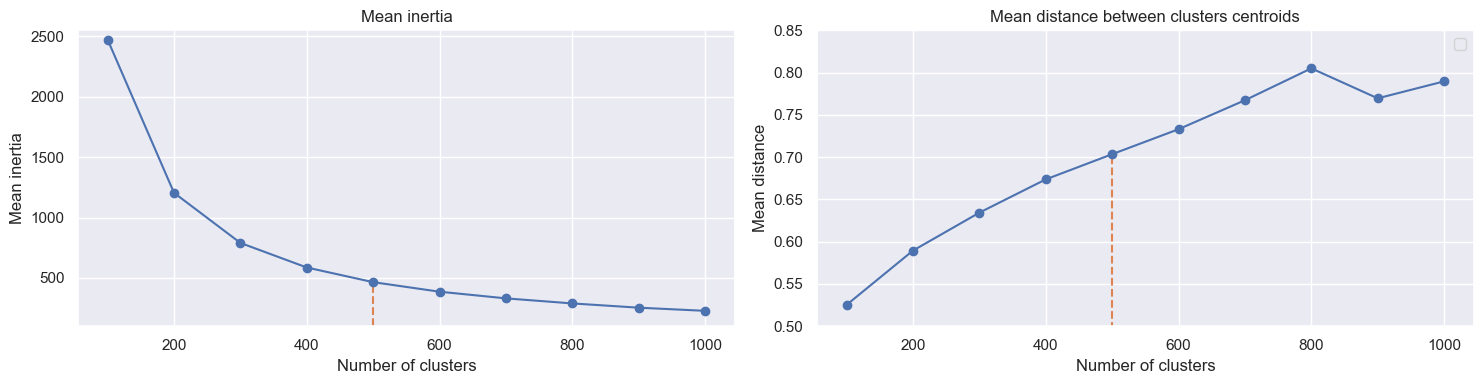

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

ax1.vlines(500, 100, 500, colors=sns.color_palette("deep")[1], linestyles="dashed")
ax1.plot(nb_clusters, mean_inertia, marker='o')
ax1.set_title("Mean inertia")
ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("Mean inertia")

ax2.vlines(500, 0, 0.7, colors=sns.color_palette("deep")[1], linestyles="dashed")
ax2.plot(nb_clusters, inter_centers_dist, marker='o')
ax1.set_ylim(100, 2550) #ax2.set_ylim(100, 2550)

#ax2.plot(nb_clusters, separability, marker='o', label="Mininum distance")

ax2.set_title("Mean distance between clusters centroids")
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("Mean distance")

ax2.set_ylim(0.5, 0.85) #ax2.set_ylim(100, 2550)

plt.legend()
plt.tight_layout()
fig.savefig("../images/phrases_kmeans_metrics.svg", format="svg", bbox_inches="tight")

### $500$ Clusters

In [12]:
all_embeds = np.array(comments_embed["Embedding"].tolist())
kmeans = MiniBatchKMeans(n_clusters=500, batch_size=1024, random_state=42, verbose=0) 
kmeans.fit(all_embeds)

centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
distances = np.linalg.norm(all_embeds - centers, axis=1)

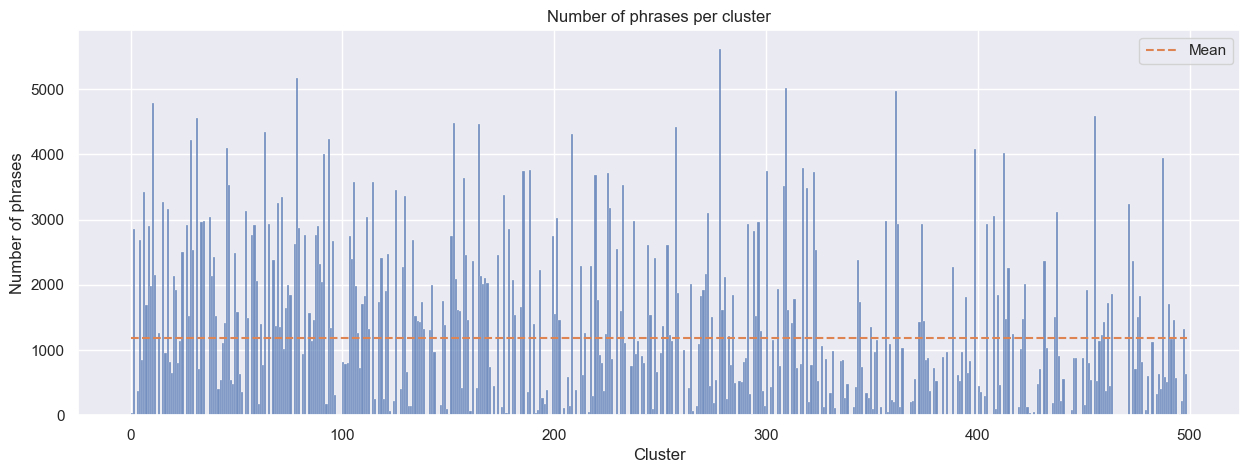

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(kmeans.labels_, ax=ax, bins=np.arange(500))
_, counts = np.unique(kmeans.labels_, return_counts=True)
plt.hlines(np.mean(counts), 0, 499, colors=sns.color_palette("deep")[1], linestyles="dashed", label="Mean")
ax.set_title("Number of phrases per cluster")
ax.set_xlabel("Cluster")
ax.set_ylabel("Number of phrases")
ax.legend()
fig.savefig("../images/phrases_count_distribution.svg", bbox_inches="tight", format="svg")

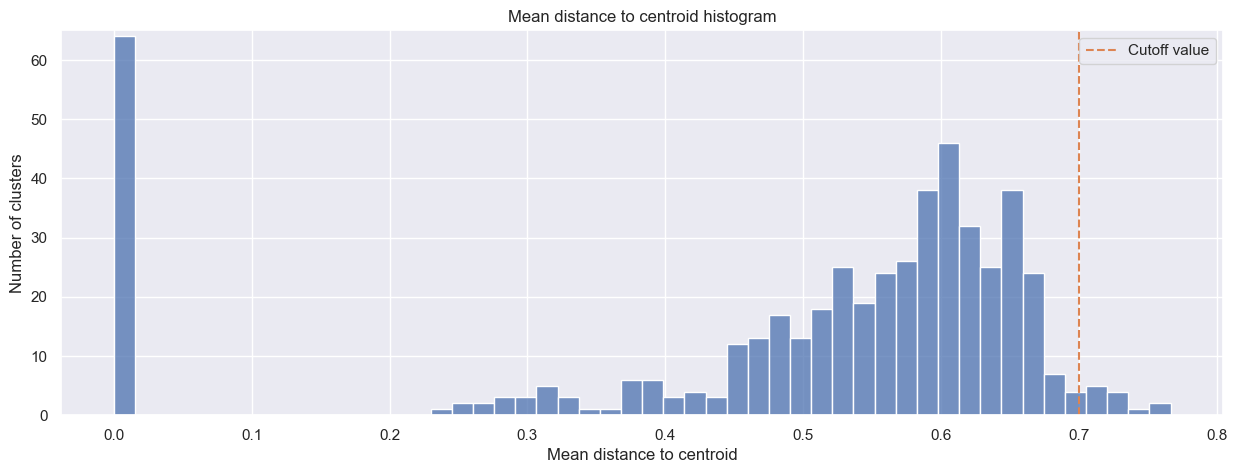

In [48]:
comments_clusters = comments_embed.assign(Cluster=kmeans.labels_, Distance_centroid=distances)
mean_dist = comments_clusters.groupby("Cluster")["Distance_centroid"].mean().reset_index()
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=mean_dist["Distance_centroid"], ax=ax, bins=50)
ax.vlines(0.7, 0, 65, colors=sns.color_palette("deep")[1], linestyles="dashed", label="Cutoff value")
ax.legend()
ax.set_ylim(0, 65)
ax.set_xlabel("Mean distance to centroid")
ax.set_ylabel("Number of clusters")
ax.set_title("Mean distance to centroid histogram")
fig.savefig("../images/phrases_mean_dist_distribution.svg", bbox_inches="tight", format="svg")

In [101]:
filtered = counts[counts >= 5]
np.arange(500)[counts > 3000], np.argsort(counts)
# 426#
comments_clusters[comments_clusters["Cluster"].isin([457])]["Phrases"].shape
#print(textwrap.fill(rev_filter[rev_filter["Game id"] == 8532]["Comment body"].iloc[3], width=100))

(1131,)

In [5]:
comments_clusters = comments_embed.assign(Cluster=kmeans.labels_, Distance_centroid=distances)
print(comments_clusters.shape)
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# count = comments_clusters["Cluster"].value_counts().reset_index()
# sns.barplot(comments_clusters["Cluster"].value_counts(), ax=ax1)
# ax1.set_xticklabels([])

mean_dist = comments_clusters.groupby("Cluster")["Distance_centroid"].mean().reset_index()
# sns.lineplot(data=mean_dist, x="Cluster", y="Distance_centroid")

comments_clusters = comments_clusters[comments_clusters["Cluster"].isin(mean_dist.loc[mean_dist["Distance_centroid"] < 0.7, "Cluster"])]
# #comments_clusters = comments_clusters[comments_clusters["Cluster"].isin(count.loc[count["count"] >= 10, "Cluster"])]

preserved_clusters = np.sort(comments_clusters["Cluster"].unique())
all_centroids = kmeans.cluster_centers_[preserved_clusters]

(591813, 8)


In [ ]:
# .parquet contains already clean clusters (see above)
#comments_clusters = pd.read_parquet("../generated_data/comments_clusters.parquet") 
#comments_clusters = comments_clusters.drop_duplicates(subset="Phrases", keep="first")

# Quantative evaluation 

In [107]:
matrix_ratings, mask_ratings, users_table, games_table = get_matrix_user_game(rev_filter)
cos_dist_matrix = calc_similarity_matrix(matrix_ratings, mask_ratings, "cos")

users_table = users_table.to_frame().reset_index().rename(columns={"index":"User index"})
games_table = games_table.to_frame().reset_index().rename(columns={"index":"Game index"})

#pos_comments_clusters = pos_comments_clusters.merge(users_table, on="User id").merge(games_table, on="Game id")
#neg_comments_clusters = neg_comments_clusters.merge(users_table, on="User id").merge(games_table, on="Game id")

## Pos / neg separation

### Note : Shannon entropy ponderation
Here, $p_k$ for each cluster is calculated as a percentage of users comments 
- High entropy -> cluster is more specific
- Low entropy -> cluster is more generic

In [ ]:
clusters_weights = cluster_weight_entropy(comments_clusters)

np.random.seed(1)
top_users = rev_filter.groupby("User id")["Game id"].count().sort_values().tail(50).index
#scores = []
for i, user in enumerate(top_users):
    print(i)
    user_score = eval_all_embeddings(user, matrix_ratings, mask_ratings, users_table, games_table, 
                           cos_dist_matrix, 40, comments_clusters, clusters_weights,
                           comments_lemmatized, lemmas, weight_type="entropy")
    
    scores.append(user_score)

0


Python(5881) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


7.6923076923076925


Python(5882) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


18.461538461538463


Python(5883) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


24.615384615384617
True


In [97]:
clusters_weights = cluster_weight_entropy(comments_clusters)

np.random.seed(1)
top_users = rev_filter.groupby("User id")["Game id"].count().sort_values().tail(50).index
scores_top = []
for i, user in enumerate(top_users):
    print(i)
    user_score = eval_all_embeddings(user, matrix_ratings, mask_ratings, users_table, games_table, 
                           cos_dist_matrix, 40, comments_clusters, clusters_weights,
                           comments_lemmatized, lemmas, weight_type="entropy")
    scores_top.append(user_score)

0
1
2
3
4
5
6
7
8
EMPTY 2272 [598] 5256
[nan, nan, nan] distant 1 [598] 5256
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
EMPTY 91 [602] 346
[nan, nan, nan] distant 1 [602] 346
47
48
49


In [ ]:
df_uni = pd.DataFrame(data=[lst2 for lst1 in scores_top for lst2 in lst1],
                       columns=["User index", "Similar users", "Random users", "Distant users", "Game id"])
# df_uni = df_uni.melt(id_vars="Game id", value_vars=["Similar users", "Random users", "Distant users"],
#                      var_name="Users type", value_name="List")
# df_uni[['User index', 'Rouge-1', 'Rouge-2', 'Bleu']] = pd.DataFrame(df_uni["List"].to_list(), columns=['User index', 'Rouge-1', 'Rouge-2', 'Bleu'])
# df_uni = df_uni.drop(columns="List")
# #df_uni = df_uni.groupby(["Users type", "User index"]).mean().reset_index()
# df_uni["Type"] = ["200 Random users"] * df_uni.shape[0]
# #df_uni.to_csv("../images/df_top.csv", index=False)
# df_uni

ValueError: 4 columns passed, passed data had 3 columns

In [91]:
#pos_clusters_weights = cluster_weight_count(pos_comments_clusters)
#neg_clusters_weights = cluster_weight_count(neg_comments_clusters)
clusters_weights = cluster_weight_entropy(comments_clusters)

np.random.seed(1)
random_users = np.random.choice(rev_filter["User id"].unique(), size=200, replace=False)
scores = []
for user in random_users:
    user_score = eval_all_embeddings(user, matrix_ratings, mask_ratings, users_table, games_table, 
                           cos_dist_matrix, 40, comments_clusters, clusters_weights,
                           comments_lemmatized, lemmas, weight_type="entropy")
    scores.append(user_score)
    print("-------------------------------") 

-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
--------

In [93]:
df_uni = pd.DataFrame(data=[lst2 for lst1 in scores for lst2 in lst1],
                       columns=["Similar users", "Random users", "Distant users"])
df_uni = df_uni.melt(value_vars=["Similar users", "Random users", "Distant users"],
                     var_name="Users type", value_name="List")
df_uni[['User index', 'Rouge-1', 'Rouge-2', 'Bleu']] = pd.DataFrame(df_uni["List"].to_list(), columns=['User index', 'Rouge-1', 'Rouge-2', 'Bleu'])
df_uni = df_uni.drop(columns="List")
#df_uni = df_uni.groupby(["Users type", "User index"]).mean().reset_index()
df_uni["Type"] = ["200 Random users"] * df_uni.shape[0]
df_uni.to_csv("../images/df_uni.csv", index=False)

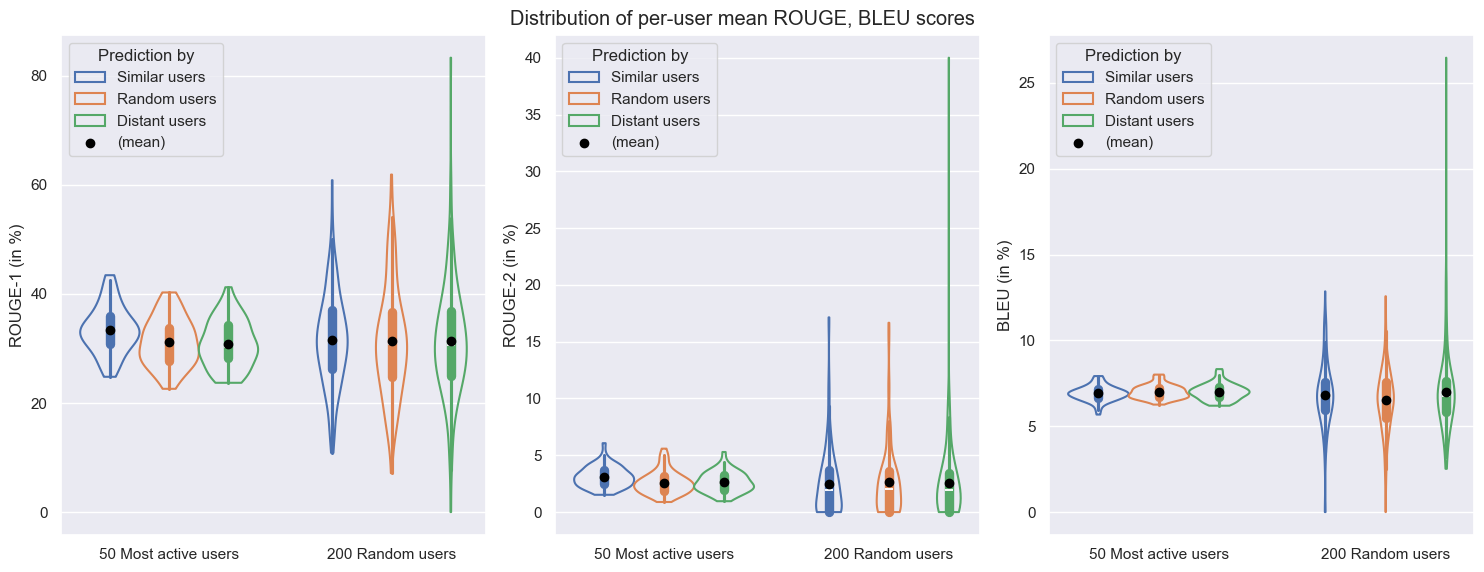

In [105]:
df_uni = pd.read_csv("../images/df_uni.csv")
df_top = pd.read_csv("../images/df_top.csv")[["User index", "Users type", "Rouge-1", "Rouge-2", "Bleu", "Type"]]

# df_uni = df_uni.groupby(["User index", "Users type", "Type"]).mean().reset_index()
# df_top = df_top.groupby(["User index", "Users type", "Type"]).mean().reset_index()

df = pd.concat([df_uni, df_top])
df = df.groupby(["User index", "Users type", "Type"]).mean().reset_index()

df = df.rename(columns={"Users type":"Prediction by", "Rouge-1":"ROUGE-1", "Rouge-2": "ROUGE-2", "Bleu":"BLEU"})
df = df.sort_values(by=["Prediction by", "Type"], ascending=False)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
sns.violinplot(data=df, x="Type", y="ROUGE-1", hue="Prediction by", ax=ax1, cut=0, fill=False)
sns.violinplot(data=df, x="Type", y="ROUGE-2", hue="Prediction by", ax=ax2, cut=0, fill=False)
sns.violinplot(data=df, x="Type", y="BLEU", hue="Prediction by", ax=ax3, cut=0, fill=False)
ax1.set_ylabel("ROUGE-1 (in %)")
ax2.set_ylabel("ROUGE-2 (in %)")
ax3.set_ylabel("BLEU (in %)")


hue_levels = df["Prediction by"].unique()
type_order = df["Type"].unique()
means = df.groupby(["Type", "Prediction by"]).mean().reset_index()

for i, type_val in enumerate(type_order):
    for j, hue_val in enumerate(hue_levels):
        subset = means[(means["Type"] == type_val) & (means["Prediction by"] == hue_val)]
        if j == 0 or j == 1:
            x_pos = i - 0.268 + 0.268 * j
        else:
            x_pos = i - 0.27 + 0.268 * j
        ax1.scatter(x_pos, subset["ROUGE-1"].values[0], marker='o', color="black", label="(mean)", zorder=10)
        ax2.scatter(x_pos, subset["ROUGE-2"].values[0], marker='o', color="black", label="(mean)", zorder=10)
        ax3.scatter(x_pos, subset["BLEU"].values[0], marker='o', color="black",label="(mean)", zorder=10)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

for ax in [ax1, ax2, ax3]:
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles)) 
    ax.legend(unique.values(), unique.keys(), title="Prediction by")

fig.suptitle("Distribution of per-user mean ROUGE, BLEU scores", y=0.95)
plt.tight_layout()
fig.savefig("../images/embeds_rouge_bleu.svg", format="svg", bbox_inches="tight")

In [173]:
df_top = pd.read_csv("../images/df_top.csv")
df_top.sort_values("Bleu", ascending=False).head(30)
#df_top[df_top["Game id"] == 4577]
#user_id = users_table[users_table["User index"] == 902]["User id"].item()
#ev_filter[(rev_filter["User id"] == user_id) & (rev_filter["Game id"] == 8454)]["Comment body"].item()
df_top=df_top.merge(users_table, on="User index").merge(rev_filter[["User id", "Game id", "Comment body"]])
#df_top[df_top["User id"] == 208].sort_values("Game id").head(27)
print(textwrap.fill(df_top[(df_top["User id"] == 201) & (df_top["Game id"] == 10409)]["Comment body"].iloc[0], width=100))
#df_top[df_top["Users type"] == "Distant users"].sort_values(["Game id", "Rouge-2"], ascending=False).head(30)
#df_top

Zombie Dice est un petit jeu de stop ou encore sans prétention mais aussi sans grande saveur. On ne
réfléchit pas beaucoup et la chance est omniprésente. Le thème bien qu'anecdotique colle finalement
bien aux mécanismes... Qu'importe ! Le but ici est plutôt de se dérouiller la cervelle (à défaut
d'en manger !) après un gros jeu ou encore pendant un apéritif. On s'amuse de la malchance des
adversaires et on se moque des prises de risque trop audacieuses qui achoppent. Même si les parties
sont très courtes, on n'en fait pas plusieurs d'affilées tant le jeu devient vite répétitif et
lassant. Zombie Dice ne restera pas dans les annales du genre. Dans la même catégorie il y a des
jeux bien plus réussis et plus attractifs tant par leur matériel que par le fun qu'ils engendrent
autour d'une table. Il ne suffit pas de coller des cerveaux sur des dés à 8 faces et une image de
zombie racoleuse sur une boite pour transformer un banal jeu de dés en distraction originale.


In [ ]:
np.random.seed(2)
game_scores, phrases = eval_all_embeddings(201, matrix_ratings, mask_ratings, users_table, games_table, cos_dist_matrix,
                                           40, comments_clusters, clusters_weights, comments_lemmatized, lemmas, "entropy", 10409)
game_scores, len(phrases)

Python(9341) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(9342) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(9343) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


([[[117, 42.5, 6.329113924050633, 5.298013245033113, 10409],
   [117, 40.0, 6.329113924050633, 7.589114025449023, 10409],
   [117, 43.75, 5.063291139240507, 7.142569012766851, 10409]]],
 3)

In [171]:
for i in range(3):
    phrases_similar = phrases[0].assign(Batch=assign_batch_number(phrases[0], 2300))
    phrases_batched = phrases_similar.groupby("Batch")["Phrases"].apply("\n ".join).tolist()

    response = call_model_by_batch(phrases_batched, "combine_phrases")
    print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

1
Nb tokens: 781
Je trouve Kahmaté à être un jeu agréable et amusant, même si on ne peut pas dire qu'il atteint le
niveau d'un vrai jeu de rugby. Il est tendu et tactique, avec des départs en trombe des joueurs
calibrés pour la course qui tentent de contourner les obstacles sans se faire attraper. Le principe
de jeu est simple : bouger deux joueurs à tour et effectuer une passe, plaquer ou botter le ballon
en respectant des règles évidentes.

Malheureusement, il fait l'impasse sur certains éléments essentiels pour un jeu de rugby, mais cela
ne nous empêche pas d'avoir du fun. Les parties sont courtes et on peut les enchaîner facilement,
avec une part de bluff et de gestion concernant l'utilisation de l'endurance de votre équipe. Le
matériel est de qualité correcte, même si on a vu mieux pour le plateau.

Mon avis est que deux points supplémentaires auraient pu améliorer le jeu, notamment pour résoudre
les conflits et ajouter un élément chaotique. Mais en fin de compte, Kahmaté est un p

In [106]:
phrases_similar = phrases[0].assign(Batch=assign_batch_number(phrases[0], 2300))
phrases_batched = phrases_similar.groupby("Batch")["Phrases"].apply("\n ".join).tolist()

response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

1
Nb tokens: 540
Voici une combinaison des phrases pour créer un commentaire sur le jeu "Zombie Dice" :

"Je vais dire que Zombie Dice est un bon choix pour un apéritif rapide et amusant, car il se joue
très vite et on passe à autre chose. Le thème est attrayant et les dés ont différentes répartitions
de faces, ce qui modifie les probabilités. Mais pour moi, le jeu est trop simpliste et aléatoire, et
je préfère apparemment les jeux plus stratégiques. Cependant, il est simple à expliquer et à jouer,
même si ça me semble un peu basique en l'état. En fin de compte, c'est un bon moyen pour discuter
avec vos amis pendant l'apéritif, mais je ne pense pas qu'il ajoute trop de profondeur au jeu."


In [178]:
phrases_random = phrases[1].assign(Batch=assign_batch_number(phrases[1], 2300))
phrases_batched = phrases_random.groupby("Batch")["Phrases"].apply("\n ".join).tolist()

response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

1
Nb tokens: 567
Voici le commentaire combiné :

C'est un jeu de société basique, mais ultra amusant ! Il repose sur le principe classique du "stop
ou encore", mais avec un thème original de zombie qui peut surprendre et déranger certaines
sensibilités. Les parties sont rapides et ne nécessitent pas trop de réflexion, ce qui en fait idéal
pour des séances courtes de 10 minutes. Le matériel est correct, sauf le "sac à dés" qui n'est pas
fourni, et il est facile de s'adapter aux règles avec un peu de pratique. Il est simple, rapide et
basé sur la chance, ce qui en fait une bonne alternative au "Jeu des cochons". En résumé, c'est un
jeu de stop ou encore très amusant et idéal pour un moment de détente.


In [109]:
phrases_distant = phrases[2].assign(Batch=assign_batch_number(phrases[2], 2300))
phrases_batched = phrases_distant.groupby("Batch")["Phrases"].apply("\n ".join).tolist()

response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

1
Nb tokens: 750
"Je l'aime ! C'est un jeu qui va faire réveiller tes neurones d'après-midi, c'est drôle, sympa et
parfait pour finir une soirée jeux avec des collègues ou la famille. Le principe est simple mais ça
fait de vous, on lance les dés, on prend des risques, on hésite... et souvent, on en sort avec le
dos au mur ! C'est un jeu qui demande un peu de stratégie, mais autant que la malchance aux dés
puisse vous faire perdre votre sain-saige pour le grand prix. Idéal pour les soirées apéritives ou
fin de session ludique quand on veut faire rire et se détendre en même temps."


In [61]:
df_top[df_top["User id"] == 208].sort_values("Game id").head(21)


,Unnamed: 0,Users type,User index,Rouge-1,Rouge-2,Bleu,Game id,Type,User id,Comment body
1023,1023,Similar users,121,51.851852,7.692308,8.860759,72,50 Most active users,208,Les + :Règles simples et variantes (surtout ce...
3259,3259,Distant users,121,44.444444,3.846154,6.748466,72,50 Most active users,208,Les + :Règles simples et variantes (surtout ce...
2141,2141,Random users,121,44.444444,7.692308,16.450240,72,50 Most active users,208,Les + :Règles simples et variantes (surtout ce...
1024,1024,Similar users,121,35.294118,3.030303,8.510638,79,50 Most active users,208,Les + : Règle simple pour enfants de 4 ansLes ...
3260,3260,Distant users,121,44.117647,6.060606,7.407407,79,50 Most active users,208,Les + : Règle simple pour enfants de 4 ansLes ...
2142,2142,Random users,121,44.117647,3.030303,9.037746,79,50 Most active users,208,Les + : Règle simple pour enfants de 4 ansLes ...
1025,1025,Similar users,121,50.000000,8.695652,6.141640,117,50 Most active users,208,Les + (par rapport à l'extension Leaders) : Un...
3261,3261,Distant users,121,37.500000,8.695652,7.821106,117,50 Most active users,208,Les + (par rapport à l'extension Leaders) : Un...
2143,2143,Random users,121,37.500000,8.695652,7.819217,117,50 Most active users,208,Les + (par rapport à l'extension Leaders) : Un...
3262,3262,Distant users,121,14.285714,0.000000,7.975460,118,50 Most active users,208,Les + (par rapport au jeu de base) : Un platea...


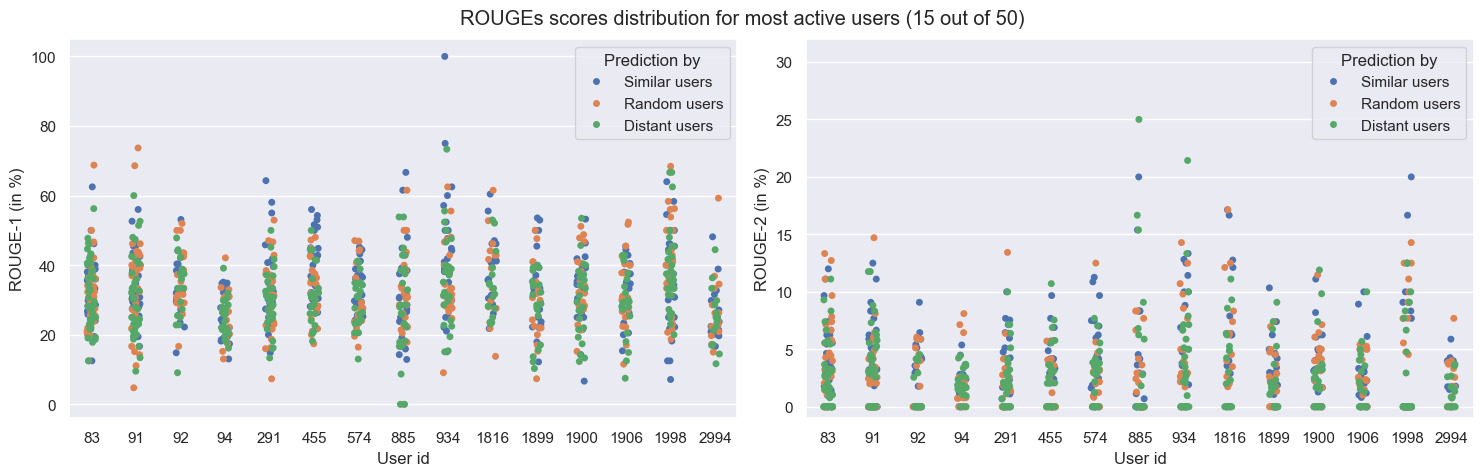

In [ ]:
np.random.seed(1)
df_top = pd.read_csv("../images/df_top.csv")
df_top = df_top.rename(columns={"Users type":"Prediction by", "Rouge-1":"ROUGE-1", "Rouge-2":"ROUGE-2"}).merge(users_table, on="User index")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
top_users_sample = np.random.choice(df_top["User index"].unique(), size=15, replace=False)
df_top = df_top[df_top["User index"].isin(top_users_sample)]

sns.stripplot(data=df_top, x="User id", y="ROUGE-1", hue="Prediction by", jitter=True, dodge=False, ax=ax1)
sns.stripplot(data=df_top, x="User id", y="ROUGE-2", hue="Prediction by", jitter=True, dodge=False, ax=ax2)

ax1.set_ylim(-4, 105)
ax2.set_ylim(-1, 32)

ax1.set_ylabel("ROUGE-1 (in %)")
ax2.set_ylabel("ROUGE-2 (in %)")

fig.suptitle("ROUGEs scores distribution for most active users (15 out of 50)", y=0.95)
plt.tight_layout()

top_users_sample, df_top["User id"].unique()
fig.savefig("../images/stripplot_top_users.svg", format="svg", bbox_inches="tight")

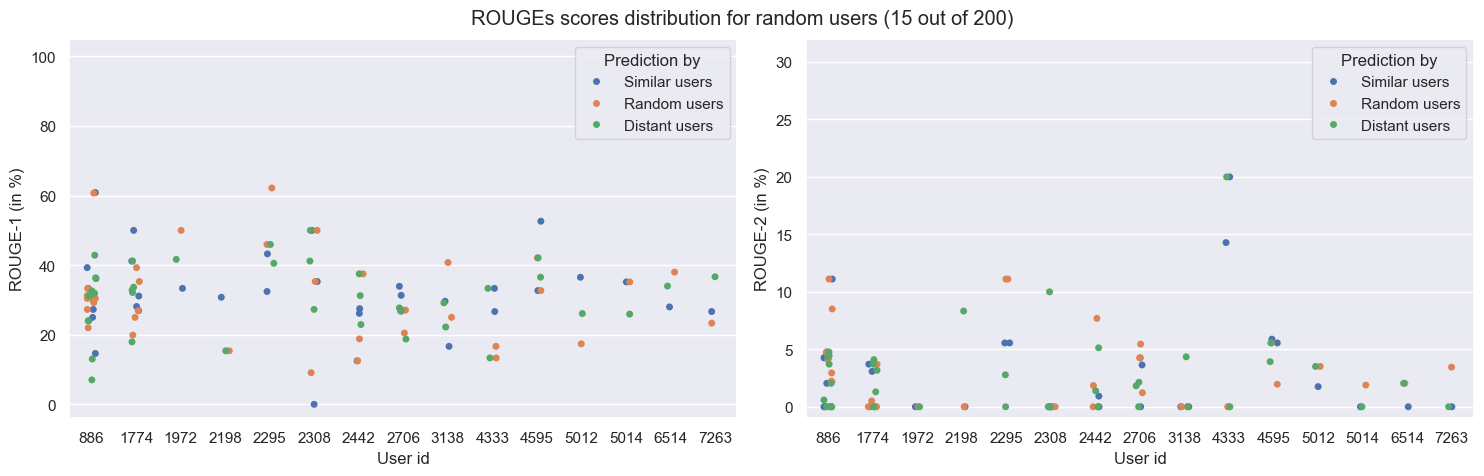

In [109]:
np.random.seed(1)
df_top = pd.read_csv("../images/df_uni.csv")
df_top = df_top.rename(columns={"Users type":"Prediction by", "Rouge-1":"ROUGE-1", "Rouge-2":"ROUGE-2"}).merge(users_table, on="User index")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
top_users_sample = np.random.choice(df_top["User index"].unique(), size=15, replace=False)
df_top = df_top[df_top["User index"].isin(top_users_sample)]

sns.stripplot(data=df_top, x="User id", y="ROUGE-1", hue="Prediction by", jitter=True, dodge=False, ax=ax1)
sns.stripplot(data=df_top, x="User id", y="ROUGE-2", hue="Prediction by", jitter=True, dodge=False, ax=ax2)

ax1.set_ylim(-4, 105)
ax2.set_ylim(-1, 32)

ax1.set_ylabel("ROUGE-1 (in %)")
ax2.set_ylabel("ROUGE-2 (in %)")

fig.suptitle("ROUGEs scores distribution for random users (15 out of 200)", y=0.95)
plt.tight_layout()
df_top["User id"].unique()
fig.savefig("../images/stripplot_random_users.svg", format="svg", bbox_inches="tight")

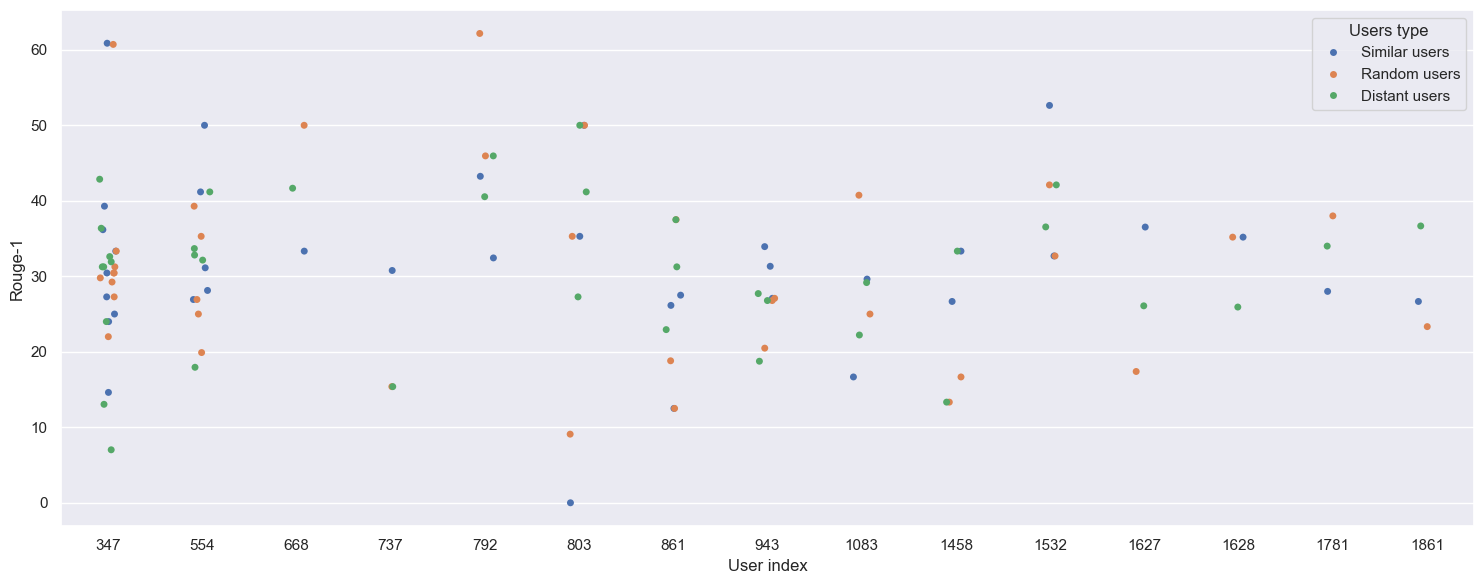

In [184]:
np.random.seed(1)
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
random_users_sample = np.random.choice(df_uni["User index"].unique(), size=15, replace=False)
df_uni = df_uni[df_uni["User index"].isin(random_users_sample)]

sns.stripplot(data=df_uni, x="User index", y="Rouge-1", hue="Users type", jitter=True)
plt.tight_layout()

In [149]:
df[df["Rouge-1"] >80]

,Users type,User index,Rouge-1,Rouge-2,Bleu,Type
553,Random users,237,85.714286,0.000000,10.344828,200 Random users
1520,Distant users,1496,83.333333,40.000000,26.470588,200 Random users
357,Similar users,362,100.000000,12.500000,9.090909,50 Most active users
674,Similar users,902,83.333333,9.090909,16.662427,50 Most active users


In [129]:
users_table[users_table["User index"] == 362]
rev_filter[(rev_filter["User id"] == 934) & (rev_filter["Game id"] == 8452)]["Comment body"].item()

"Renouvelle très bien le jeuIndispensable pour des parties à 6 joueurs...Si si c'est possible !!"

In [119]:
df_uni = pd.DataFrame(data=[lst2 for lst1 in scores_top for lst2 in lst1],
                       columns=["Similar users", "Random users", "Distant users"])
df_uni = df_uni.melt(value_vars=["Similar users", "Random users", "Distant users"],
                     var_name="Users type", value_name="List")
df_uni[['User index', 'Rouge-1', 'Rouge-2', 'Bleu', 'Game id']] = pd.DataFrame(df_uni["List"].to_list(), columns=['User index', 'Rouge-1', 'Rouge-2', 'Bleu', 'Game id'])
df_uni = df_uni.drop(columns="List")
df_uni["Type"] = ["50 Most active users"] * df_uni.shape[0]
df_uni.to_csv("../images/df_top.csv")

Text(0, 0.5, 'ROUGE-1 (in %)')

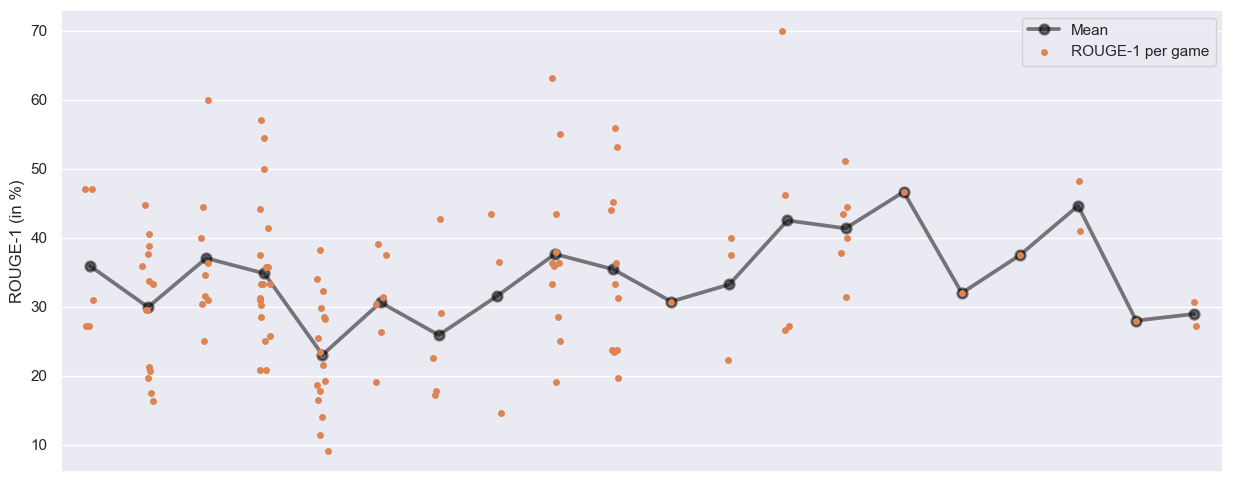

In [82]:
df_top_all = pd.read_csv("../images/df_random_all.csv")
palette = sns.color_palette("deep")

fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))


np.random.seed(0)
users
users = np.random.choice(df_top_all["User index"].unique(), size=20, replace=False)
df_top_all = df_top_all[df_top_all["User index"].isin(users)]


sns.pointplot(data=df_top_all[df_top_all["Users type"] == "Similar users"], x="User index", y="Rouge-1", ax=ax1, errorbar=None,
              color='black', alpha=0.5, label="Mean")
sns.stripplot(data=df_top_all[df_top_all["Users type"] == "Similar users"], x="User index", y="Rouge-1", ax=ax1, color=palette[1], label="ROUGE-1 per game")

handles, labels = ax1.get_legend_handles_labels()
unique = dict(zip(labels, handles))  # keeps first occurrence
ax1.legend(unique.values(), unique.keys())
ax1.get_xaxis().set_visible(False)
ax1.set_xlabel("Users")
ax1.set_ylabel("ROUGE-1 (in %)")

<Axes: xlabel='Type', ylabel='Rouge-1'>

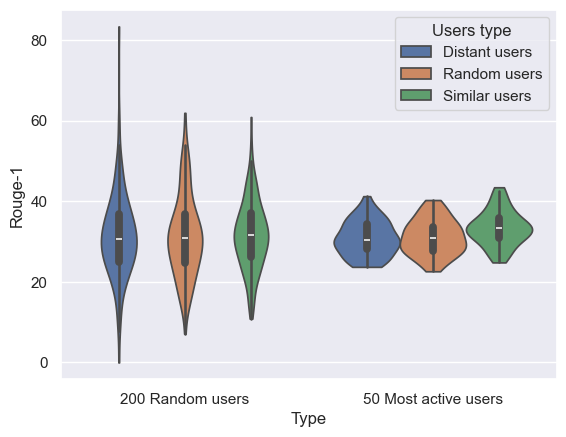

In [9]:
# df_uni = pd.DataFrame(data=[lst2 for lst1 in scores for lst2 in lst1],
#                        columns=["Similar users", "Random users", "Distant users"])
# df_uni = df_uni.melt(value_vars=["Similar users", "Random users", "Distant users"],
#                      var_name="Users type", value_name="List")
# df_uni[['User index', 'Rouge-1', 'Rouge-2', 'Bleu']] = pd.DataFrame(df_uni["List"].to_list(), columns=['User index', 'Rouge-1', 'Rouge-2', 'Bleu'])
# df_uni = df_uni.drop(columns="List")
# df_uni = df_uni.groupby(["Users type", "User index"]).mean().reset_index()
# df_uni["Type"] = ["200 Random users"] * df_uni.shape[0]


df_uni = pd.read_csv("../images/df_uni.csv")
df_top = pd.read_csv("../images/df_top.csv")
df = pd.concat([df_uni, df_top])
df

sns.violinplot(data=df, x="Type", y="Rouge-1", hue="Users type", cut=0)

<Axes: xlabel='Type', ylabel='Rouge-2'>

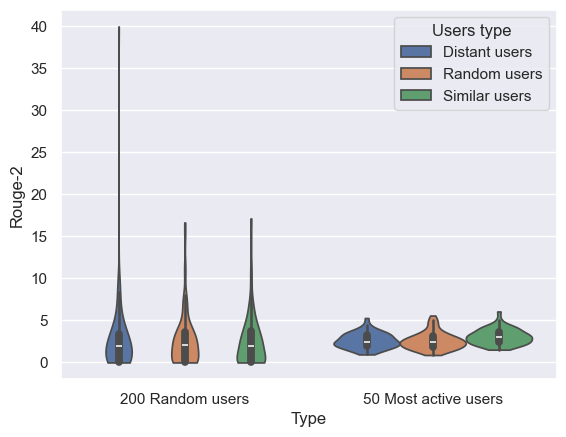

In [15]:
sns.violinplot(data=df, x="Type", y="Rouge-2", hue="Users type", cut=0)

In [ ]:
# User index = 1496 -> outlier
df_uni[df_uni["Rouge-1"] == df_uni["Rouge-1"].max()], df_uni[df_uni["Rouge-2"] == df_uni["Rouge-2"].max()], df_uni[df_uni["Bleu"] == df_uni["Bleu"].max()]

(        Users type  User index    Rouge-1  Rouge-2       Bleu  \
 119  Distant users        1496  83.333333     40.0  26.470588   
 
                  Type  
 119  200 Random users  ,
         Users type  User index    Rouge-1  Rouge-2       Bleu  \
 119  Distant users        1496  83.333333     40.0  26.470588   
 
                  Type  
 119  200 Random users  ,
         Users type  User index    Rouge-1  Rouge-2       Bleu  \
 119  Distant users        1496  83.333333     40.0  26.470588   
 
                  Type  
 119  200 Random users  )

In [275]:
df_uni.sort_values("Bleu", ascending=False).head(100)["Users type"].value_counts()

Users type
Distant users    34
Similar users    33
Random users     33
Name: count, dtype: int64

In [253]:
df_uni[df_uni["User index"] == 1496]

,Users type,User index,Rouge-1,Rouge-2,Bleu,Type
119,Distant users,1496,83.333333,40.0,26.470588,200 Random users
265,Random users,1496,50.000000,0.0,11.742663,200 Random users
411,Similar users,1496,50.000000,0.0,8.571429,200 Random users


In [252]:

rev_filter[rev_filter["User id"].isin(users_table[users_table["User index"] == 1496]["User id"])]

,Game id,User id,Game name UI,Username,Datetime,Rating,Comment title,Comment body,index,Length
9986,10497,4483,¡Rescate! Fire Rescue,FiReTiTi,2012-09-24 12:29:06,0.038462,"Sauvez mon chat, je vous en supplie !... BOOM....",Un très bon jeu coopératif et amusant. On peut...,16814,58
12652,8790,4483,Suburbia,FiReTiTi,2013-09-04 08:45:17,-6.261538,Bof... et pas plus,Tout est dans le titre.Je n'ai absolument pas ...,20520,17
21192,2552,4483,Dixit : Quest,FiReTiTi,2013-09-30 00:54:16,1.738462,Superbe extension,De nouvelles cartes superbes au niveau du jeu ...,34443,11
29505,8302,4483,Shadows over Camelot,FiReTiTi,2013-09-30 00:34:09,-1.861538,Ouille mes neurones,"Un bon jeu bien prise de tête.Nombreux, il sem...",45919,16
34958,2165,4483,Cyclades : Hades,FiReTiTi,2012-09-24 12:29:06,0.038462,"Attention, Hades arrive !!!","Hades, un dieu qui fait peur, TRES peur !!!Je ...",53499,76
35369,6907,4483,Olympos : Oikoumene,FiReTiTi,2012-09-24 12:29:06,2.038462,Une extension parfaite,Cette extension pour Olympos est simplement su...,54152,25
45504,8534,4483,Space Hulk - Death Angel,FiReTiTi,2011-07-27 12:29:01,-1.961538,Feu sur tout ce qui bouge,"Un jeu coopératif sympathique, mais super diff...",68092,15
47592,618,4483,Asteroyds,FiReTiTi,2011-07-25 12:29:01,0.038462,Bon jeu,"Jeu de programmation très sympathique, surtout...",71186,30
50971,8520,4483,Space Alert,FiReTiTi,2012-09-24 12:29:06,2.038462,Un RoboRally collaboratif et mortel,"Voici un jeu génialissime, facile à expliquer ...",75751,59
51297,10381,4483,Zero,FiReTiTi,2011-07-26 12:29:01,0.038462,Bien sympathique,Un bon petit jeu de fin de soirée.Mais attenti...,76238,20


In [ ]:
#pos_clusters_weights = cluster_weight_count(pos_comments_clusters)
#neg_clusters_weights = cluster_weight_count(neg_comments_clusters)
clusters_weights = cluster_weight_entropy(comments_clusters)

np.random.seed(1)
random_users = np.random.choice(rev_filter["User id"].unique(), size=200, replace=False)
bigrams, unigrams = [], [] 

for user in random_users:
    u, b = eval_all_embeddings(user, matrix_ratings, mask_ratings, users_table, games_table, 
                           cos_dist_matrix, 40, comments_clusters, clusters_weights,
                           comments_lemmatized, lemmas, weight_type="entropy")
    bigrams.append(b)
    unigrams.append(u)
    print("-------------------------------") 

['gloire rome', 'piocher commune principal', 'mauvais piocher', 'fois jouer partir fluidite installer devenir agreable', 'passer cap partir jeu devenir fluide rapide', 'dire si piocher cela si cela si', 'aller sens|sen si imaginer auteur bien', 'jeu dense petit jeu', 'jeu gros joueur', 'si minimum gamer ne hesiter pas', 'jeu', 'fois partie eloigner avouer pas controle envie recommencer', 'fois partie terminer envie refaire', 'chercher jeu gros rejouabilite partir ne pas chose', 'jeu ne enchainer pas partir ressortir'] rome ne pas partie mettre moment editer etre avis monter baisser noter trouver jeu tres aimer jeu carte effet riche profond condition fin partie nombreux effet batiment falloir cesse adapter revanche clair bout partie ne maitriser pas baser frustration etaler combo fin jeu coup gout inachever vouloir relancer partie saisir contrer adversaire combiner effet eau envier fort rejouer ne mettre jeu decouvrir monde ne rentrer pas jeu joueur occasionnel derouter bordel nom plate

IndexError: list index out of range

<Axes: xlabel='Users type', ylabel='ROUGE score (in %)'>

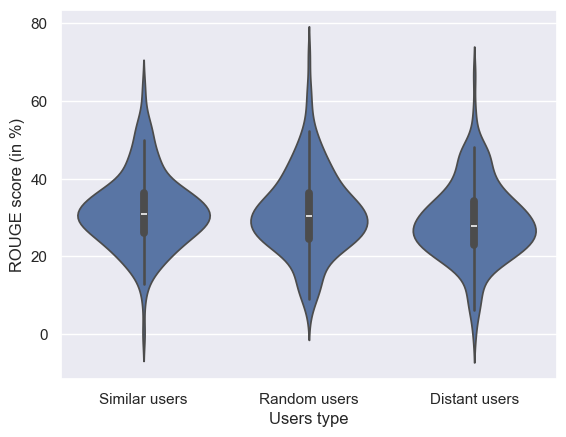

In [ ]:
bigrams

[[[1178, 4.3478260869565215, 3.260869565217391, 5.434782608695652]],
 [[989, 0.0, 0.0, 0.0]],
 [[772, 1.8867924528301887, 0.0, 0.0],
  [772, 1.4925373134328357, 1.4925373134328357, 1.4925373134328357],
  [772, 2.0202020202020203, 0.0, 1.0101010101010102],
  [772, 0.8264462809917356, 1.6528925619834711, 0.8264462809917356],
  [772, 1.2048192771084338, 1.2048192771084338, 0.0],
  [772, 4.040404040404041, 1.0101010101010102, 0.0],
  [772, 3.9215686274509802, 0.9803921568627451, 0.9803921568627451],
  [772, 1.2345679012345678, 0.0, 1.2345679012345678],
  [772, 1.7391304347826086, 0.8695652173913043, 4.3478260869565215],
  [772, 2.5, 0.0, 1.25],
  [772, 2.0, 0.0, 2.0],
  [772, 0.8130081300813009, 0.8130081300813009, 2.4390243902439024],
  [772, 0.7692307692307693, 3.8461538461538463, 0.7692307692307693],
  [772, 2.564102564102564, 1.282051282051282, 1.282051282051282],
  [772, 2.7777777777777777, 2.7777777777777777, 1.3888888888888888],
  [772, 1.2195121951219512, 2.4390243902439024, 0.0],


,User index,Users type,ROUGE score (in %)
0,8,Similar users,10.000000
1,10,Similar users,2.857143
2,26,Similar users,0.649351
3,29,Similar users,1.698802
4,48,Similar users,2.295383
...,...,...,...
478,1844,Distant users,0.000000
479,1855,Distant users,0.000000
480,1861,Distant users,0.000000
481,1888,Distant users,9.561404


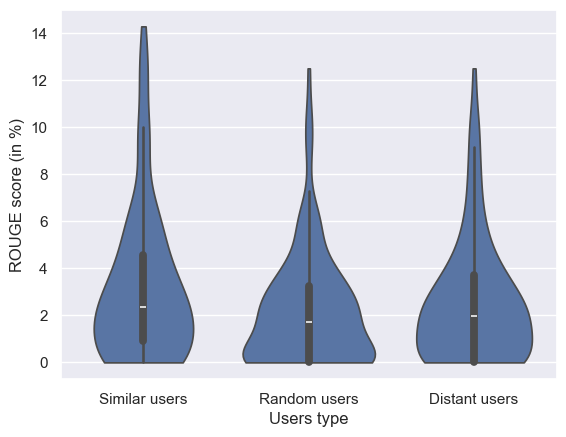

In [ ]:
df_big = pd.DataFrame(data=[lst2 for lst1 in bigrams for lst2 in lst1],
                       columns=["User index", "Similar users", "Random users", "Distant users"])
df_big = df_big.groupby("User index").mean().reset_index()
df_big = df_big.melt(id_vars=["User index"], value_vars=["Similar users", "Random users", "Distant users"],
                     var_name="Users type", value_name="ROUGE score (in %)")
ax = sns.violinplot(data=df_big, x="Users type", y="ROUGE score (in %)", cut=0)
# ax.set_ylim(0, 20)
df_big

In [ ]:
games_table[games_table["Game index"] == 2466] # 9792
comments_lemmatized[(comments_lemmatized["User id"] == 2303) & (comments_lemmatized["Game id"] == 9792)]

,Comment line,Lemma,Game id,User id,index
27214,42684,suite digne digne suite suite onirim plonger u...,9792,2303,42684


In [ ]:
users.tail(70)

User id
578      212
3427     212
1907     212
1939     214
1917     219
        ... 
201      619
91       651
1        758
83       778
208     1111
Name: Game id, Length: 70, dtype: int64

In [ ]:
np.mean(bigrams[0], axis=0), np.mean(unigrams[0], axis=0)

(array([121.        ,   2.37364399,   2.13062397,   1.54292828]),
 array([121.        ,  29.29000746,  26.43147438,  26.40576244]))

0 0
0 1
1 0
1 1


Text(272.9166666666667, 0.5, 'Random users')

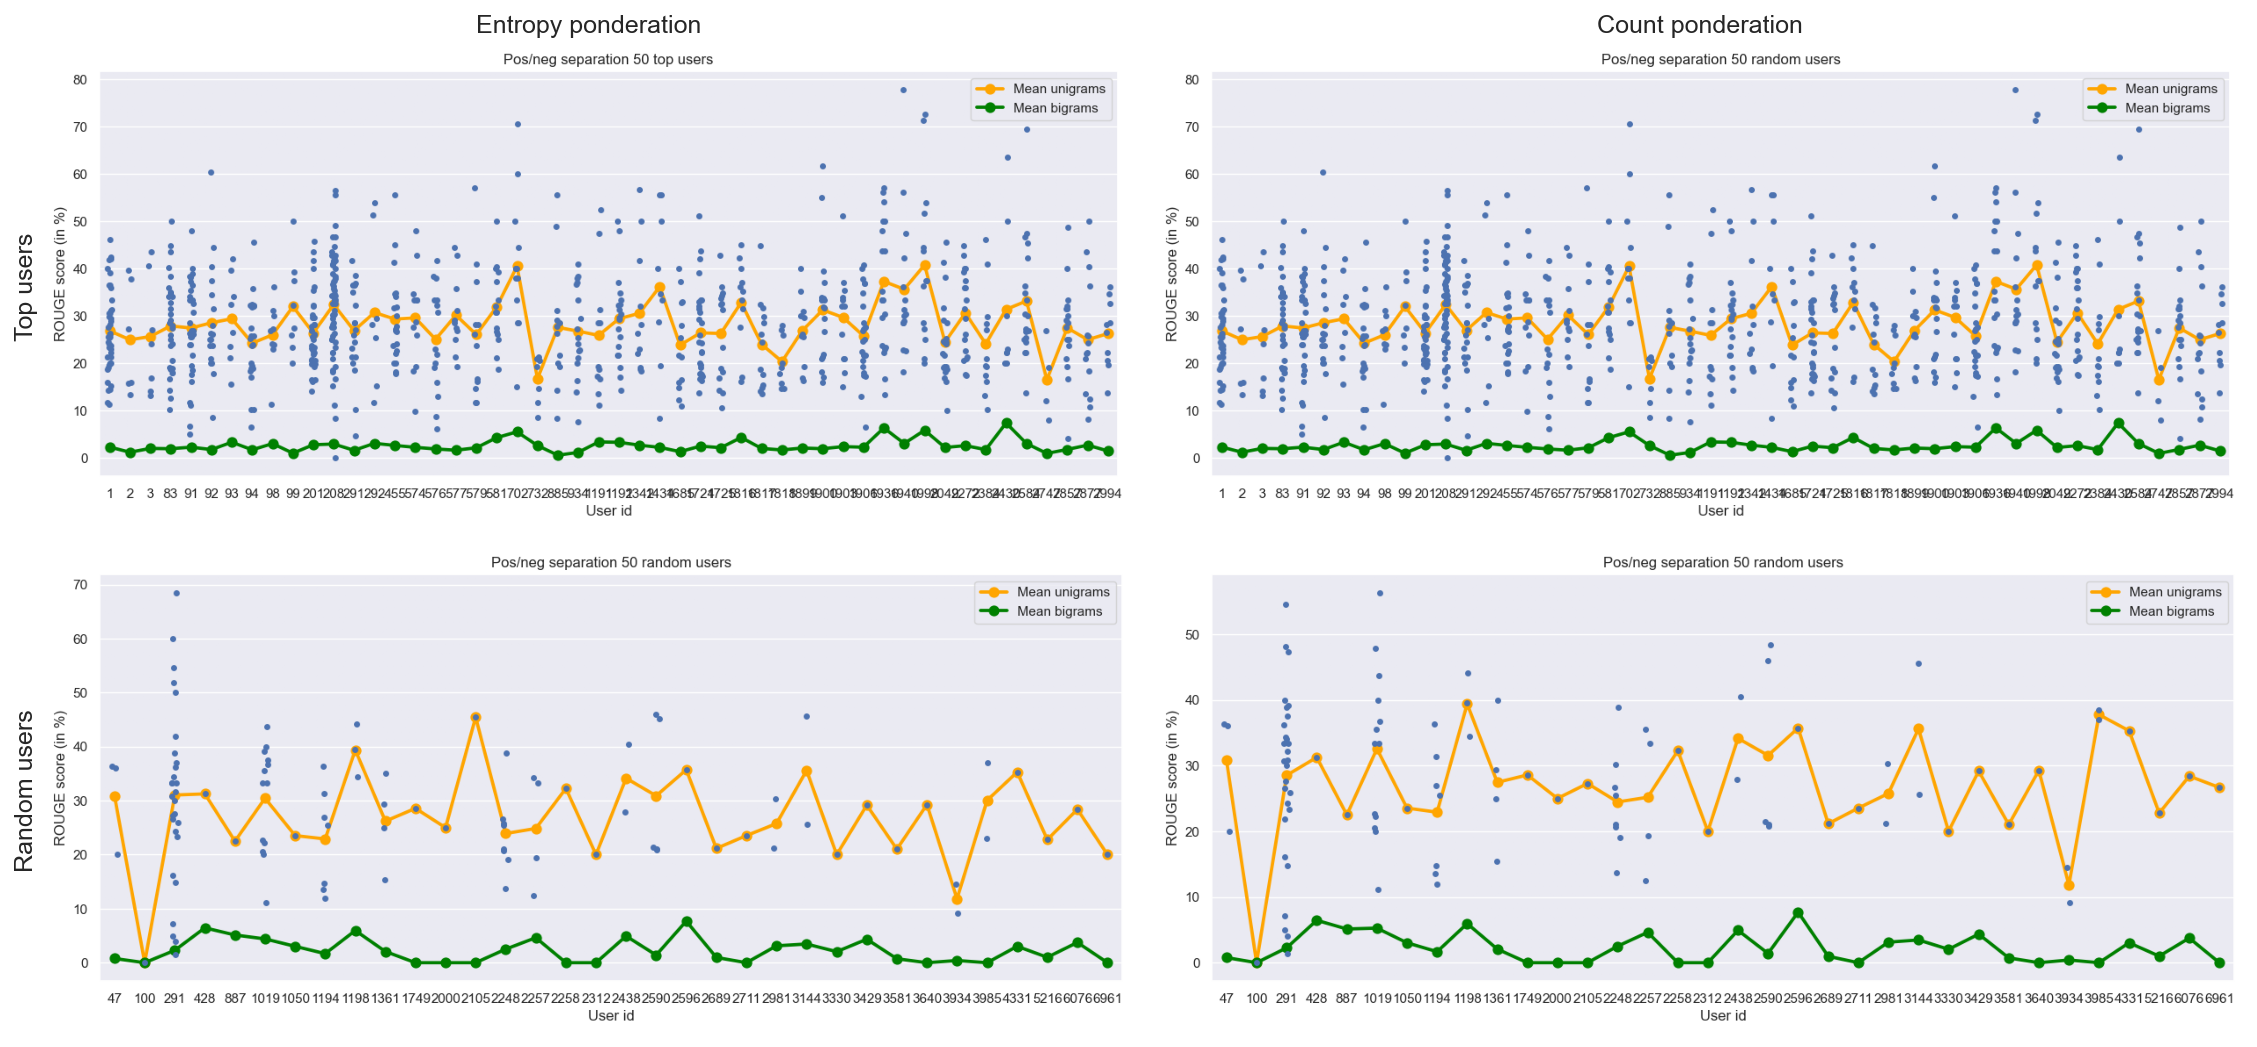

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 7), dpi=150)
folder = "../generated_data/embeds_eval"
im00, im10 = plt.imread(f"{folder}/entropy/pos_neg_top.png"), plt.imread(f"{folder}/entropy/pos_neg_random.png")
im01, im11 = plt.imread(f"{folder}/count/pos_neg_top.png"), plt.imread(f"{folder}/count/pos_neg_random.png")
images = [im00, im01, im10, im11]

for i, j in product(range(2), repeat=2):
    print(i, j)
    axes[i, j].imshow(images[i * 2 + j])
    axes[i, j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    axes[i, j].grid(False)
plt.tight_layout()

axes[0, 0].set_title("Entropy ponderation")
axes[0, 0].set_ylabel("Top users")

axes[0, 1].set_title("Count ponderation")

axes[1, 0].set_ylabel("Random users")

## No pos/neg separation

Text(0.5, 1.0, 'Count ponderation')

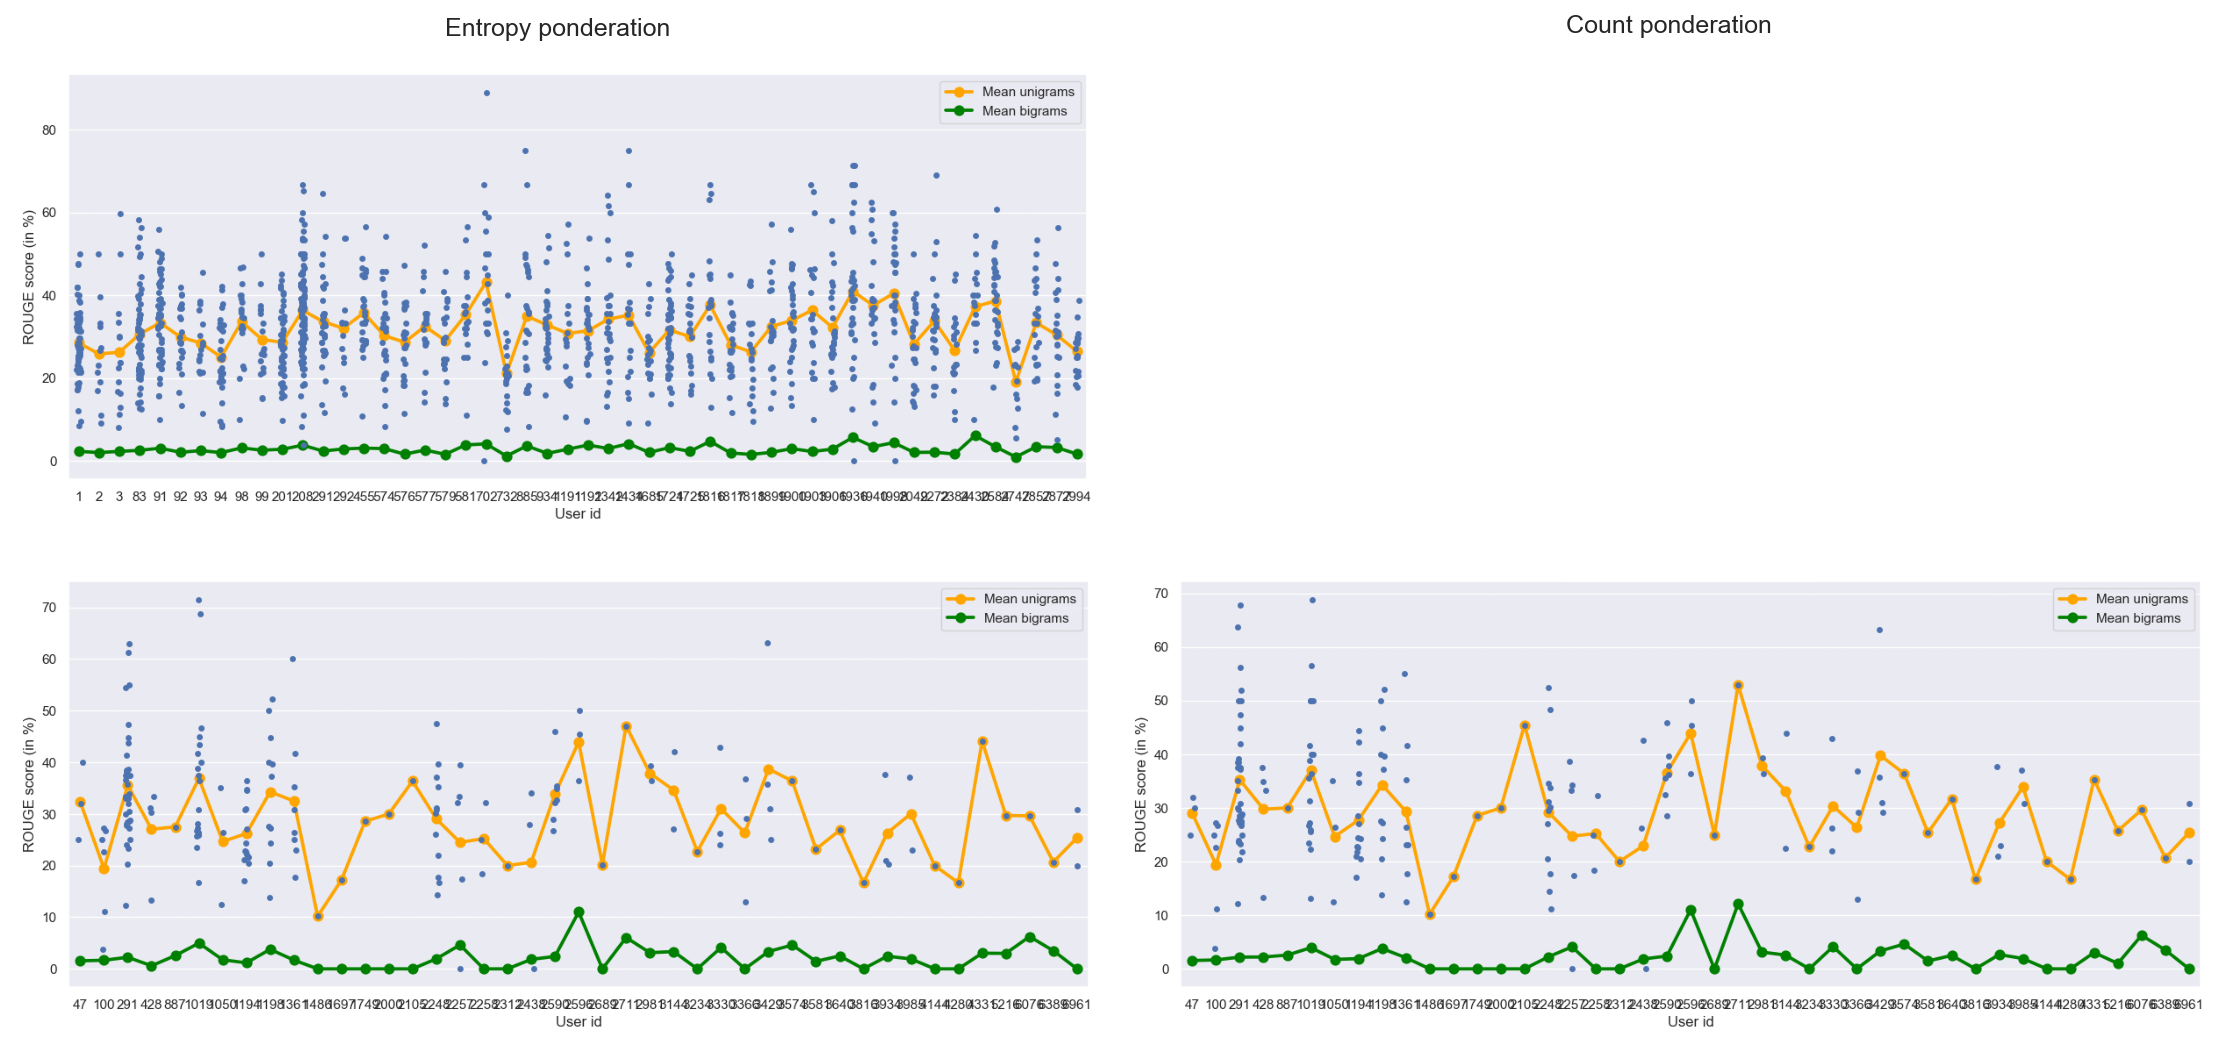

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 7), dpi=150)
folder = "../generated_data/embeds_eval"
im00, im10 = plt.imread(f"{folder}/entropy/all_top.png"), plt.imread(f"{folder}/entropy/all_random.png")
im11 = plt.imread(f"{folder}/count/all_random.png")
images = [im00, im10, im11]

for i, j in product(range(2), repeat=2):
    if i == 0 and j == 1:
        axes[i, j].set_axis_off()
    else:
        axes[i, j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    axes[i, j].grid(False)

axes[0, 0].imshow(images[0])
axes[1, 0].imshow(images[1])
axes[1, 1].imshow(images[2])
plt.tight_layout()

axes[0, 0].set_title("Entropy ponderation")
axes[0, 1].set_title("Count ponderation")

# Qualitative analysis

## Pos/neg separation

**User 0, Game 9146**

In [ ]:
print(textwrap.fill(rev_filter[(rev_filter["User id"] == 0) & (rev_filter["Game id"] == 9146)]["Comment body"].item(), width=100))

Très bien vu, Monsieur Sing ! Depuis votre console de Cap Canaveral, vous avez fort bien réussi à
marier le jeu de plis et le jeu coopératif. Il faut aimer les jeux de plis, certes. Mais pour ceux
qui n'aiment pas, l'aspect coopératif / puzzle-game pourrait prendre le dessus. Il faut aimer les
jeux coopératifs, d'accord. Mais pour ceux qui n'aiment pas, cela reste un vrai jeu de plis avec une
forme d'annonce. Au lieu d'avoir le "cul entre deux chaises", l'alliance renforce la somme des deux
aspects. Il faut même parfois se retenir, comme vous le diront les "ultras d'Hanabi", de ne pas
soulever un sourcil ou de s'exclamer d'un "OOOuuuh oui, trop bien !" lorsqu'un pli se passe comme
vous l'aviez prévu ! Parce que, qu'on le veuille ou non, ce sont des communications qui donnent des
infos supplémentaires simplifiant potentiellement la teneur du défi. Pourtant quel délice de vivre
entre amis ces regards lourds de sens, mais potentiellement incompréhensible, puisque l'informations
n'est que 

**All $3$ similar clusters**

In [ ]:
pos_clusters_weights = cluster_weight_entropy(pos_comments_clusters)
neg_clusters_weights = cluster_weight_entropy(neg_comments_clusters)

user, game = 0, 9146
phrases = eval_embeddings(user, matrix_ratings, mask_ratings, 
                                users_table, games_table, cos_dist_matrix, 
                                40, users_means, pos_comments_clusters, neg_comments_clusters,
                                pos_clusters_weights, neg_clusters_weights, pod_centroids, neg_centroids,
                                comments_lemmatized, lemmas, specific_game=game, weight_type="entropy")

phrases = phrases.assign(Batch=assign_batch_number(phrases, 2300))
phrases_batched = phrases.groupby("Batch")["Phrases"].apply("\n ".join).tolist()
response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Correct predicted ratings neg : 1, pos : 0 (1 hidden)
game 9146 number of similar users comments 40 n clusters 3 phrases per cluster 1 1
Nb tokens: 281
Voici une possible commentaire sur le board game :

"Je pense que nous avons trouvé un trésor ! 'Il va falloir agrandir la capsule' pour que nous
puissions exploiter toutes les possibilités de jeu, car 'il va alors falloir s'étendre' dans les
différents plans d'action. En tout cas, il faudra 'faire avec' une certaine dose de stratégie et de
ruse, car c'est un peu 'ruser' pour gagner contre ses adversaires. Mais en fin de compte, ce jeu est
vraiment 'très malin', avec des mécanismes qui vous feront 'se creuser les méninges' pour comprendre
comment jouer correctement. C'est un excellent exemple du genre de jeu qui va faire entrer encore
plus de monde dans le monde merveilleux du jeu de société moderne, où la coopération et la
compétition se mélangent pour créer une expérience unique. Et avec ses missions à remplir et son
système de pli ul

**User 1, Game 3370**

In [ ]:
print(textwrap.fill(rev_filter[(rev_filter["User id"] == 1) & (rev_filter["Game id"] == 8444)]["Comment body"].item(), width=100))

Small islands avec ses belles couleurs et son principe de tuiles à poser trompe d’entrée le joueur
qui n’ y voit qu’un énième jeu à la Carcassonne (moi). Un quart de partie plus tard on s’aperçoit
que l’on a fait fausse route et que le jeu vaut bien mieux que cet hâtif à priori. Car ici on
remplit les objectifs à chaque fin de manche, et cela va très vite. Pas la peine de faire l’île la
plus grande, il faut multiplier les lieux pour scorer un max. Un jeu plus profond que l’on croit, et
sur lequel on revient en mode « cette fois on est prévenu, ce ne sera pas la même !»


**Pos/neg**

In [ ]:
pos_clusters_weights = cluster_weight_entropy(pos_comments_clusters)
neg_clusters_weights = cluster_weight_entropy(neg_comments_clusters)

user, game = 1, 8444
phrases = eval_embeddings(user, matrix_ratings, mask_ratings, 
                                users_table, games_table, cos_dist_matrix, 
                                40, users_means, pos_comments_clusters, neg_comments_clusters,
                                pos_clusters_weights, neg_clusters_weights, pod_centroids, neg_centroids,
                                comments_lemmatized, lemmas, specific_game=game, weight_type="entropy")

print("Nb of selected phrases", phrases.shape[0])

phrases = phrases.assign(Batch=assign_batch_number(phrases, 2300))
phrases_batched = phrases.groupby("Batch")["Phrases"].apply("\n ".join).tolist()
response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Correct predicted ratings neg : 0, pos : 1 (1 hidden)
Init 4
game 8444 number of similar users comments 40 n clusters 4 phrases per cluster 1 Nb of selected phrases 12
1
Nb tokens: 354
Voici une possible commentaire du joueur :

"Joli petit jeu familial de pose de tuiles dans un univers fleuri et ensoleillé, pour ce petit jeu
de pose de tuiles sans prétention, qui ravira la famille réunie. Je le mettrais dans la lignée de
Carcassone : jeu familial de pose de tuiles ! Une variante propose des cartes objectifs modulables
ainsi qu'un mode solo. Et aussi une machine à variantes (du genre donner la carte au joueur plutôt
que ne faire que la montrer. - Les cartes Change sont un petit plus et permettront une adaptabilité
plus importante. Les règles sont simples : valider et scorer au mieux sa carte objectif à chaque
manche en plaçant stratégiquement ses tuiles ou jetons. On joue une manche jusqu'à ce que le nombre
de cartes placées dans chaque colonne soit égal ou supérieur à la valeur des ob

**No pos/neg, count**

In [ ]:
clusters_weights = cluster_weight_count(comments_clusters)

user, game = 1, 8444
phrases = eval_embeddings(user, matrix_ratings, mask_ratings, 
                                users_table, games_table, cos_dist_matrix, 
                                40, users_means, comments_clusters, comments_clusters,
                                clusters_weights, clusters_weights, all_centroids, all_centroids,
                                comments_lemmatized, lemmas, specific_game=game, weight_type="count")

print("Nb of selected phrases", phrases.shape[0])

phrases = phrases.assign(Batch=assign_batch_number(phrases, 2300))
phrases_batched = phrases.groupby("Batch")["Phrases"].apply("\n ".join).tolist()
response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Correct predicted ratings neg : 0, pos : 1 (1 hidden)
Init 6
game 8444 number of similar users comments 48 n clusters 6 phrases per cluster 1 Nb of selected phrases 12
1
Nb tokens: 415
Voici un commentaire possible :

"Je suis vraiment impressionné par ce charmant jeu de pose de tuiles, 'Small Islands' ! La réflexion
tranquille et l'élégance sont bien présentes dans le gameplay, qui offre une sensation de fraîcheur
et de fluidité. Les règles sont simples, mais cela ne signifie pas que le jeu est prévisible.
Lorsque vous arrivez sur les îles des autres joueurs, vous devrez partagez vos tuiles et vous
adapter à la situation. Le principe de base est simple : valider et scorer au mieux votre carte
objectif en plaçant vos tuiles ou jetons de manière stratégique. Mais ce qui rend ce jeu vraiment
intéressant, c'est le mode solo et les cartes objectifs modulables qui vous permettent de jouer à
votre rythme et de chasser les énigmes. Donc, laissez-lui une chance à 'Small Islands' ! Vous allez
a

**User 0, Game 9146**

In [ ]:
print(textwrap.fill(rev_filter[(rev_filter["User id"] == 0) & (rev_filter["Game id"] == 9146)]["Comment body"].item(), width=100))

Très bien vu, Monsieur Sing ! Depuis votre console de Cap Canaveral, vous avez fort bien réussi à
marier le jeu de plis et le jeu coopératif. Il faut aimer les jeux de plis, certes. Mais pour ceux
qui n'aiment pas, l'aspect coopératif / puzzle-game pourrait prendre le dessus. Il faut aimer les
jeux coopératifs, d'accord. Mais pour ceux qui n'aiment pas, cela reste un vrai jeu de plis avec une
forme d'annonce. Au lieu d'avoir le "cul entre deux chaises", l'alliance renforce la somme des deux
aspects. Il faut même parfois se retenir, comme vous le diront les "ultras d'Hanabi", de ne pas
soulever un sourcil ou de s'exclamer d'un "OOOuuuh oui, trop bien !" lorsqu'un pli se passe comme
vous l'aviez prévu ! Parce que, qu'on le veuille ou non, ce sont des communications qui donnent des
infos supplémentaires simplifiant potentiellement la teneur du défi. Pourtant quel délice de vivre
entre amis ces regards lourds de sens, mais potentiellement incompréhensible, puisque l'informations
n'est que 

**Choose clusters based on entropy 50/50, pos/neg**

In [ ]:
pos_clusters_weights = cluster_weight_entropy(pos_comments_clusters)
neg_clusters_weights = cluster_weight_entropy(neg_comments_clusters)

user, game = 0, 9146
phrases = eval_embeddings(user, matrix_ratings, mask_ratings, 
                                users_table, games_table, cos_dist_matrix, 
                                40, users_means, pos_comments_clusters, neg_comments_clusters,
                                pos_clusters_weights, neg_clusters_weights, pod_centroids, neg_centroids,
                                comments_lemmatized, lemmas, specific_game=game, weight_type="entropy")

print("Nb of selected phrases", phrases.shape[0])

phrases = phrases.assign(Batch=assign_batch_number(phrases, 2300))
phrases_batched = phrases.groupby("Batch")["Phrases"].apply("\n ".join).tolist()
response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Correct predicted ratings neg : 1, pos : 0 (1 hidden)
Init 3
game 9146 number of similar users comments 40 n clusters 3 phrases per cluster 1 Nb of selected phrases 15
1
Nb tokens: 281
Voici une possible commentaire des utilisateurs :

"Je trouve que le jeu est vraiment très malin et tendu ! Il va falloir faire avec les règles un peu
compliquées, mais ça vaut la peine. En tout cas, il faudra se creuser les méninges pour comprendre
toutes les combinaisons possibles. C'est assez malin, et j'aime ça ! Le genre de jeu qui va faire
entrer encore plus de monde dans le monde merveilleux du jeu de société moderne est ici, avec un
excellent jeu de pli ultra classique qui allie jeu de développement et d'échange dans un mélange
très réussi. Un grand classique, alors !"


**Choose clusters based on count 50/50, pos/neg**

In [ ]:
pos_clusters_weights = cluster_weight_count(pos_comments_clusters)
neg_clusters_weights = cluster_weight_count(neg_comments_clusters)

user, game = 0, 9146
phrases = eval_embeddings(user, matrix_ratings, mask_ratings, 
                                users_table, games_table, cos_dist_matrix, 
                                40, users_means, pos_comments_clusters, neg_comments_clusters,
                                pos_clusters_weights, neg_clusters_weights, pod_centroids, neg_centroids,
                                comments_lemmatized, lemmas, specific_game=game, weight_type="count")

print("Nb of selected phrases", phrases.shape[0])

phrases = phrases.assign(Batch=assign_batch_number(phrases, 2300))
phrases_batched = phrases.groupby("Batch")["Phrases"].apply("\n ".join).tolist()
response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Correct predicted ratings neg : 1, pos : 0 (1 hidden)
Init 3
game 9146 number of similar users comments 40 n clusters 3 phrases per cluster 1 Nb of selected phrases 15
1
Nb tokens: 281
Voici une possible commentaire d'un joueur sur un board game :

"Ce grand classique allie jeu de développement et d'échange dans un mélange très réussi. Un
excellent jeu de pli ultra classique avec une couche de coopération sur fond de missions à remplir.
Le genre de jeu qui va faire entrer encore plus de monde dans le monde merveilleux du jeu de société
moderne. Mais c'est très tendu, il va falloir ruser et s'étendre pour gagner ! Il va falloir
agrandir la capsule pour trouver les meilleures stratégies. En tout cas, il faudra se creuser les
méninges pour comprendre toutes les règles et combinaisons possibles. Mais c'est vraiment très malin
et très retors, ca rajoute une dimension supplémentaire au jeu en ajoutant plus de combinaisons
possibles. Et bien sûr, un jeu qui donne envie de rentrer dans le mond

**Choose clusters based on count 50/50, no pos/neg**

In [ ]:
clusters_weights = cluster_weight_count(comments_clusters)

user, game = 0, 9146
phrases = eval_embeddings(user, matrix_ratings, mask_ratings, 
                                users_table, games_table, cos_dist_matrix, 
                                40, users_means, comments_clusters, comments_clusters,
                                clusters_weights, clusters_weights, all_centroids, all_centroids,
                                comments_lemmatized, lemmas, specific_game=game, weight_type="count")

print("Nb of selected phrases", phrases.shape[0])

phrases = phrases.assign(Batch=assign_batch_number(phrases, 2300))
phrases_batched = phrases.groupby("Batch")["Phrases"].apply("\n ".join).tolist()
response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Correct predicted ratings neg : 1, pos : 0 (1 hidden)
Init 8
game 9146 number of similar users comments 64 n clusters 8 phrases per cluster 1 Nb of selected phrases 16
1
Nb tokens: 380
D'après mon avis complet sur le site L'emeeplejaune (Lien ici), je peux dire que ce jeu est une
véritable merveille du monde merveilleux du jeu de société moderne ! Il faut agrandir la capsule
pour laisser place à sa grande complexité et à ses mécanismes d'affrontements classiques qui
fonctionnent parfaitement. C'est un jeu ultra-classique avec une couche de coopération sur fond de
missions à remplir, ce qui en fait un excellent choix pour les fans de jeux de société.

Mais attention, il faut être très malin et très retors pour en tirer toutes les bénéfices ! Le jeu
est étonnant et détonnant, comme un grand coup de tonnerre dans le ciel ludique. Il est également
coopératif indispensable aux sensations différentes, déroutantes et envoutantes.

Je dirais que ce jeu est un véritable chef-d'œuvre dans une to